**Lab 4** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Machine Learning for Audio and Acoustic Engineering***
---

Implementation on PyTorch


# **Lab 4: Neural Networks (II)**
---

In this lab we will continue exploring different types of deep architectures for audio processing, and we will pay special attention to system evaluation.


In [1]:
# As always, we import the relevant packages
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn           # it contains the neural network modules
import torch.nn.functional as F # it contains the activation functions
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import librosa
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Device Selection

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS

Device Check:

In [3]:
device

device(type='mps')

### **Exercise 1**: Data Preparation I

We will continue working with the ESC-50 dataset. Download it to your notebook following the same steps as in Lab 2 and Lab 3.

Create a list containing the audio files and another one with the corresponding labels (as in Lab 3):

In [4]:
fn_csv = '/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Selected Topics in Music and Acoustic Engineering/Git/Sound-Event-Classification/ESC-50-master/meta/esc50.csv'

files = []  # File list
labels = []  # Class list

df = pd.read_csv(fn_csv)

#unique class labels
unique_classes = df['category'].unique()

Instead of working with 50 classes, we limit our dataset to only 10 classes. Filter you two files (the one with file paths and the one with labels) to contain only those belonging to classes [0-9].

In [5]:
# 10 first classes
our_classes = unique_classes[0:10]
print("First 10 classes:", our_classes)

# Filter the dataset to only include the selected classes
filtered_df = df.query('category in @our_classes')

files = filtered_df['filename'].values
labels = filtered_df['category'].values

First 10 classes: ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw']


We load the signals and get the Mel spectrogram for each signal. Create a list called "signals" storing the raw waveforms of each file in your list and another one called "melspecs" that stores the Mel spectrogram for each signal.

Note: use the default parameters for librosa.load (resample to 22050Hz) and librosa.feature.melspectrogram.

In [6]:
path = '/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Selected Topics in Music and Acoustic Engineering/Git/Sound-Event-Classification/ESC-50-master/audio/'
signals = list(librosa.load(path + file)[0] for file in files)

signal1, sr = librosa.load(path + '1-100032-A-0.wav')
print(f"Sample rate:", sr, "Hz")

melspecs = list(librosa.feature.melspectrogram(y=signal, sr=sr) for signal in signals)

Sample rate: 22050 Hz


### **Exercise 2**: Data preparation II



Convert your "melspecs" and "labels" list to numpy arrays, called "Xdata" and "Ydata".
Check that the result has size (400, 128, 216) for Xdata and (400,) for Ydata.

In [7]:
Xdata = np.asarray(melspecs)

# Transform the labels to numbers
label_mapping = {label: idx for idx, label in enumerate(dict.fromkeys(labels))}
numerical_labels = np.array([label_mapping[label] for label in labels])

Ydata = np.asarray(numerical_labels)

print('Xdata shape: {} \nYata shape: {}'.format(Xdata.shape, Ydata.shape))

Xdata shape: (400, 128, 216) 
Yata shape: (400,)


Check that Ydata is balanced by plotting the histogram.

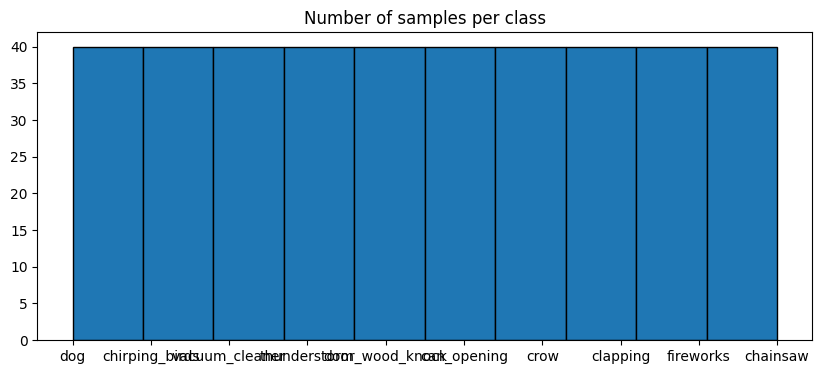

In [8]:
plt.figure(figsize=(10, 4))
plt.title("Number of samples per class")
plt.hist(labels, bins=10,edgecolor='black')
plt.show()

As we can see from the histogram, we have exactly the same number of element for each class.

Split your dataset into 3 partitions, 1 for training (70%), 1 for validation (20%) and 1 for test (10%). Check that the resulting arrays have the correct shape:

In [9]:
seed = 42 # We set a seed for reproducibility

X_train, X_temp, y_train, y_temp = train_test_split(Xdata, Ydata, train_size=0.7, random_state=seed, stratify=Ydata) #we use stratify to keep the same distribution of classes in the training set

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=seed, stratify=y_temp)  #we use stratify to keep the same distribution of classes in the validation and test sets
print('X_train shape: {} \nX_val shape: {} \nX_test shape: {} \ny_train shape: {} \ny_val shape: {} \ny_test shape: {} \n'.format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))

X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

print('X_train_rs shape: {} \nX_val_rs shape: {} \nX_test_rs shape: {}'.format(X_train_rs.shape, X_val_rs.shape, X_test_rs.shape))

X_train_rss_swapped = np.expand_dims(X_train_rs, -1)
X_val_rss_swapped = np.expand_dims(X_val_rs, -1)
X_test_rss_swapped = np.expand_dims(X_test_rs, -1)

X_train_rss = np.swapaxes(X_train_rss_swapped, -2, -1)
X_val_rss = np.swapaxes(X_val_rss_swapped, -2, -1)
X_test_rss = np.swapaxes(X_test_rss_swapped, -2, -1)

print(f'Original size X_train_rs.shape=', X_train_rs.shape, '; X_val_rs.shape=', X_val_rs.shape, '; X_test_rs.shape=', X_test_rs.shape)
print(f'New size X_train_rss.shape=X_train_rss.shape', X_train_rss.shape, '; X_val_rss.shape=', X_val_rss.shape, '; X_test_rss.shape=', X_test_rss.shape)


X_train shape: (280, 128, 216) 
X_val shape: (80, 128, 216) 
X_test shape: (40, 128, 216) 
y_train shape: (280,) 
y_val shape: (80,) 
y_test shape: (40,) 

X_train_rs shape: (280, 216, 128) 
X_val_rs shape: (80, 216, 128) 
X_test_rs shape: (40, 216, 128)
Original size X_train_rs.shape= (280, 216, 128) ; X_val_rs.shape= (80, 216, 128) ; X_test_rs.shape= (40, 216, 128)
New size X_train_rss.shape=X_train_rss.shape (280, 216, 1, 128) ; X_val_rss.shape= (80, 216, 1, 128) ; X_test_rss.shape= (40, 216, 1, 128)


Expected output:
```
X_train shape: (280, 128, 216)
X_val shape: (80, 128, 216)
X_test shape: (40, 128, 216)
y_train shape: (280,)
y_val shape: (80,)
y_test shape: (40,)
```

In the next exercise we will create a time-distributed 1D-CNN to process our dataset. By default, Keras assumes that the last dimension corresponds to the number of channels in our input. Since we are going to use 1D-CNN, each frequency band will be processed as an independent frequency channel. Therefore, we need to reorder the dimensions in our data to move the frequency channels to the last dimension.

Use the numpy function "moveaxis" to create the data matrices X_train_rs, X_val_rs and X_test_rs, with dimensions (280, 216, 128), (80, 216, 128) and (40, 216, 128):

Expected output:
```
X_train_rs shape: (280, 216, 128)
X_val_rs shape: (80, 216, 128)
X_test_rs shape: (40, 216, 128)
```

### **Exercise 7**: Hybrid CNN-RNN

In this last exercise we are going to mix our previous time-distributed model with a LSTM layer to create a Hybrid CNN-RNN architecture.

Adapt your previous time-distributed model to match the following summary:

In [10]:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #

# Time-Dist Conv1D             (None, None, 120, 16)     160
# _________________________________________________________________
# Time-Dist MaxPool1D 1D       (None, None, 60, 16)      0
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 60, 16)      0
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 58, 16)      784
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 29, 16)      0
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 29, 16)      0
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 27, 32)      1568
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 27, 32)      0
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 14, 32)      0
# _________________________________________________________________
# Time-Dist Flatten            (None, None, 448)         0
# _________________________________________________________________
# LSTM  (16 neurons)           (None, None, 16)          29760
# _________________________________________________________________
# Global Av. Pooling 1D        (None, 16)                0
# _________________________________________________________________
# Dropout (0.35)               (None, 16)                0
# _________________________________________________________________
# Dense                        (None, 10)                170

# Total params: 32,442
# Trainable params: 32,442
# Non-trainable params: 0
# _________________________________________________________________


This time, we assign names to the layers in order to recognise them in the summary.

1. TensorFlow’s TimeDistributed applies a layer independently to each timestep. In PyTorch, we handle this by reshaping and using shared weights.
2. Padding is set to 0 to match padding='same' loosely; you may adjust padding manually for exact match.
3. The LSTM is followed by GlobalAveragePooling1D, which is implemented as mean over time steps.

In [11]:
class CNN_LSTM_Hybrid(nn.Module):
    def __init__(self, num_classes=10, dropout_cnn=0.5, dropout_lstm=0.35, input_length=128):
        super(CNN_LSTM_Hybrid, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9)  # TimeDistributed Conv1D
        self.pool1 = nn.MaxPool1d(kernel_size=2, padding=0)

        self.conv2 = nn.Conv1d(16, 16, kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=2, padding=0)

        self.conv3 = nn.Conv1d(16, 32, kernel_size=3)
        self.pool3 = nn.MaxPool1d(kernel_size=2, padding=0)

        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Dynamically compute flatten_size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            out = self.pool1(F.relu(self.conv1(dummy)))
            out = self.dropout_cnn(out)
            out = self.pool2(F.relu(self.conv2(out)))
            out = self.dropout_cnn(out)
            out = self.pool3(F.relu(self.conv3(out)))
            out = self.dropout_cnn(out)
            flatten_size = out.shape[1] * out.shape[2]

        self.flatten_size = flatten_size

        self.lstm = nn.LSTM(input_size=self.flatten_size, hidden_size=16, batch_first=True)

        self.dropout_lstm = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, length = x.size()
        x = x.view(-1, channels, length)  # (B * T, C, L)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout_cnn(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout_cnn(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout_cnn(x)

        x = x.view(batch_size, seq_len, -1)  # (B, T, features)

        lstm_out, _ = self.lstm(x)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling1D

        x = self.dropout_lstm(lstm_out)
        x = self.fc(x)
        return x

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=1000, patience=100):
    model.to(device)
    best_acc = 0
    best_epoch = 0
    best_model_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

        train_acc = correct / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += (predicted == targets).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1}")
    model.load_state_dict(best_model_state)
    return model, history


In [13]:
def plot_training_history(history):

    epochs = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [14]:
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(targets.numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test accuracy: {accuracy:.4f}")


In [15]:
class RSSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # shape: (B, T, C, L)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

(280, 216, 1, 128) (280,)
(80, 216, 1, 128) (80,)
(40, 216, 1, 128) (40,)
Epoch 1: Train Acc: 0.0821, Val Acc: 0.1500
Epoch 2: Train Acc: 0.1250, Val Acc: 0.2250
Epoch 3: Train Acc: 0.2000, Val Acc: 0.3125
Epoch 4: Train Acc: 0.2107, Val Acc: 0.3750
Epoch 5: Train Acc: 0.2464, Val Acc: 0.4000
Epoch 6: Train Acc: 0.3214, Val Acc: 0.3875
Epoch 7: Train Acc: 0.3286, Val Acc: 0.4125
Epoch 8: Train Acc: 0.4000, Val Acc: 0.4375
Epoch 9: Train Acc: 0.3821, Val Acc: 0.4375
Epoch 10: Train Acc: 0.4143, Val Acc: 0.4250
Epoch 11: Train Acc: 0.4036, Val Acc: 0.4500
Epoch 12: Train Acc: 0.4500, Val Acc: 0.5000
Epoch 13: Train Acc: 0.4179, Val Acc: 0.4500
Epoch 14: Train Acc: 0.4357, Val Acc: 0.4625
Epoch 15: Train Acc: 0.4714, Val Acc: 0.4375
Epoch 16: Train Acc: 0.4821, Val Acc: 0.4625
Epoch 17: Train Acc: 0.4714, Val Acc: 0.4750
Epoch 18: Train Acc: 0.4607, Val Acc: 0.4625
Epoch 19: Train Acc: 0.4679, Val Acc: 0.5250
Epoch 20: Train Acc: 0.5036, Val Acc: 0.4625
Epoch 21: Train Acc: 0.4643, Val Ac

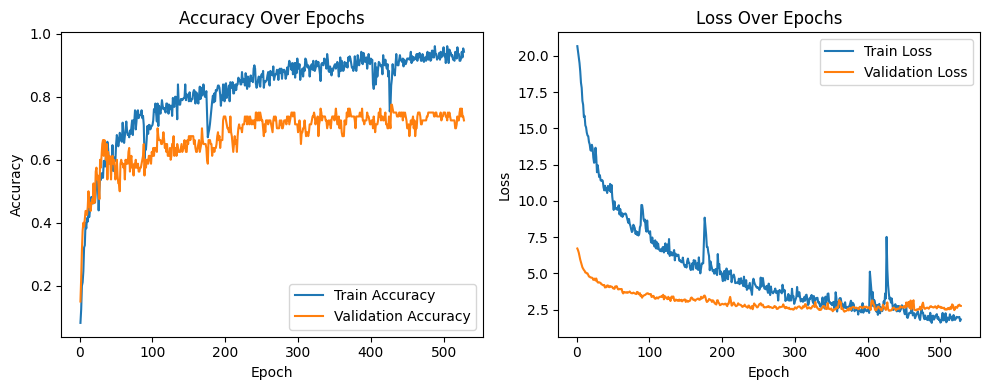

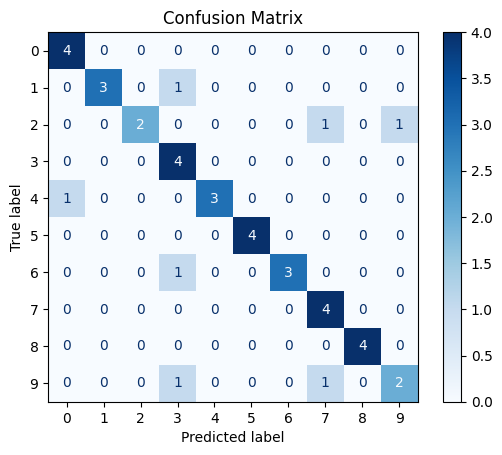

Test accuracy: 0.8250


In [ ]:
# Creazione dei dataset
train_dataset = RSSDataset(X_train_rss, y_train)
val_dataset = RSSDataset(X_val_rss, y_val)
test_dataset = RSSDataset(X_test_rss, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model = CNN_LSTM_Hybrid()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device)

plot_training_history(history)
evaluate_model(model, test_loader, device)